# Solving for the Efficient Frontier in Stock Portfolios

<a href="https://www.kaggle.com/code/addarm/solving-the-efficient-frontier-in-stocks" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<!-- @import "[TOC]" {cmd="toc" depthFrom=1 depthTo=6 orderedList=false} -->

![Riding the efficient frontier MidJourney 11.2023](https://raw.githubusercontent.com/adamd1985/quant_research/main/images/frontier_banner.png)

The Efficient Frontier, a core concept in Harry Markowitz's Modern Portfolio Theory (MPT), is used in quantitative finance to build optimal portfolios that offer the highest expected return for a given level of risk. 

It is constructed by diversifying assets to find the best risk-return trade-off, which we will do in this article, through python and free financial data. The resulting universe of assets and portfolios should lie on the **efficient frontier**.

## Prepare your Environment

Have a jupyter environment ready, and `pip install` these libraries:
- numpy
- pandas
- yfinance

You'll need access to [analysis_utils](./analysis_utils.py) library for common functions.

In [34]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import dotenv
%load_ext dotenv

import warnings
warnings.filterwarnings("ignore")

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'

if IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle...')
    %pip install yfinance
    %pip install statsmodels
    %pip install seaborn
    %pip install itertools
    %pip install scikit-learn

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print('Running Local...')

import yfinance as yf
from analysis_utils import calculate_profit, load_ticker_prices_ts_df, plot_strategy, load_ticker_ts_df

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
Running Local...


Before we start, let's load two uncorrelated securities from the latest post-covid market regime (2020-2023) to build a test portfolio:

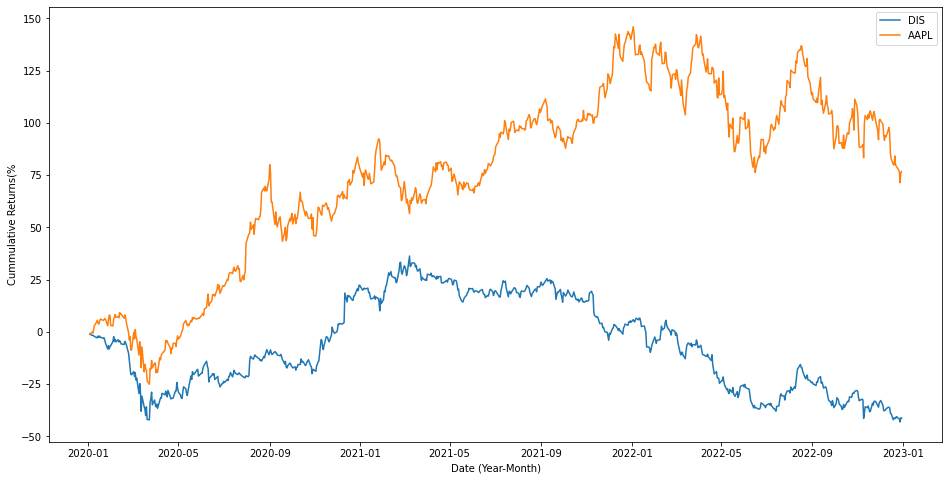

In [35]:
tickers = ["DIS", "AAPL"]

START_DATE = "2020-01-01"
END_DATE = "2022-12-31"

tickers_orig_df = load_ticker_prices_ts_df(tickers, START_DATE, END_DATE)
tickers_df = tickers_orig_df.dropna(axis=1).pct_change().dropna()  # first % is NaN

# 1+ to allow the cumulative product of returns over time, and -1 to remove it at the end.
tickers_df = (1 + tickers_df).cumprod() - 1

plt.figure(figsize=(16, 8))
for ticker in tickers_df.columns:
    plt.plot(tickers_df.index, tickers_df[ticker] * 100.0, label=ticker)

plt.xlabel("Date (Year-Month)")
plt.ylabel("Cummulative Returns(%")
plt.legend()
plt.show()

For each stock above `(i)`, we are interested in:
- The mean historic returns, which we will use as expected returns `E(Ri)` (a naive, but common assumption in MPT).
- The variance `var(i)` or `sigma(i)^2`, and the normalized standard deviaion `sigma(i)`.
- Price weights `Xi`, which we will allocate or calculate throughout this article.

In [36]:
mean_returns = tickers_df.mean()
highest_returns = tickers_df.max()
lowest_returns = tickers_df.min()
std_deviation = tickers_df.std()
summary_table = pd.DataFrame(
    {
        "Highest ret (%)": highest_returns * 100.0,
        "Average ret (%)": mean_returns * 100.0,
        "Lowest ret (%)": lowest_returns * 100.0,
        "Deviation (%)": std_deviation * 100.0,
    }
)
summary_table.transpose()

,DIS,AAPL
Highest ret (%),36.241571,145.997846
Average ret (%),-6.270797,75.853096
Lowest ret (%),-43.205128,-25.119850
Deviation (%),21.495119,41.827597


# Investment Preferences with Indifference Curves

To understand the efficient fontier we need to experiment with the investors choices of risk/reward, through indifference curves.
The curves model satisfaction (or utility) from investment decisions, and help to visualize the optimal positions to take.
We use opportunity sets to outline viable combinations of assets' risk and returns, within linear budget constraints. 

Assume the following opportunities:
1. We have a 5% risk free return (at the time of writing 11.2023)
2. We have a choice of taking no risk for 5%, or taking ~40% risk for ~140% gains wih AAPL.

Let's assume this is a risk averse investor, we model them by this utility function:
$$ U(x) = x + ax^2 + bx + c $$
- `x` is the risk from 1 to 100%
- `a^2` & `bx` are the quadratic (and concave curve, as we penalize risk) and linear terms (sensitivity to variance with positive slope, we want more returns with more risk).
- `c` is a constant of increasing utility or satisfaction, incrementing it by 10 to create 3 curves.
The goal of the investor is to go up and to the left curves, to increase their utility. This means nothing under the `low utility` intersection, and nothing higher than `moderate utility` curve, because there is no opportunity.

The optimal choice is when the opportunity set line is tangent to a curve, in our case the `moderate` utility curve, giving us 70% returns for 10% risk. 

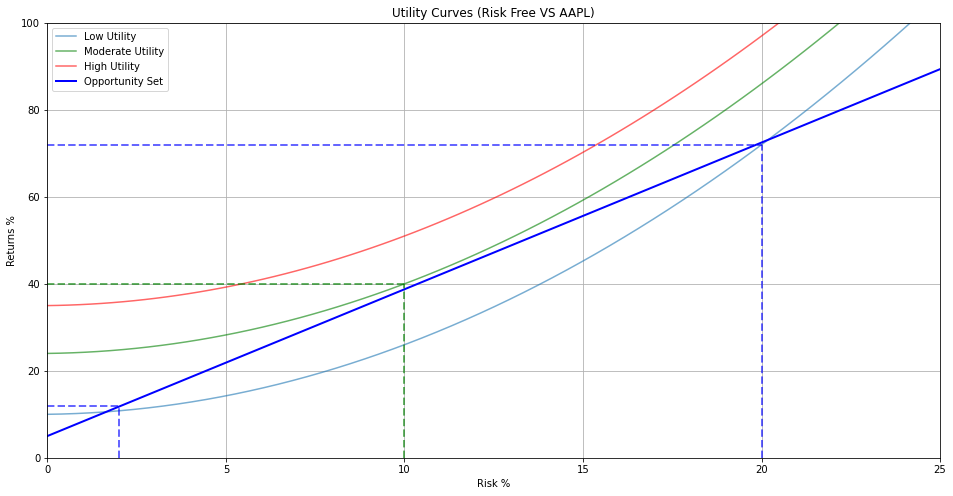

In [37]:
def utility_fn(x, a=0.15, b=0.1, c=1):
    return a * x**2 + b * x + c


plt.figure(figsize=(16, 8))

x_values_1 = np.linspace(0, 40, 100)
y_values_1 = utility_fn(x_values_1, c=10)
plt.plot(x_values_1, y_values_1, label="Low Utility", alpha=0.6)

x_values_2 = np.linspace(0, 35, 100)
y_values_2 = utility_fn(x_values_2, c=24)
plt.plot(x_values_2, y_values_2, label="Moderate Utility", color="g", alpha=0.6)

x_values_3 = np.linspace(0, 30, 100)
y_values_3 = utility_fn(x_values_3, c=35)
plt.plot(x_values_3, y_values_3, label="High Utility", color="r", alpha=0.6)

plt.plot([0, 40], [5, 140], label="Opportunity Set", color="b", linewidth=2)

plt.plot([2, 2], [0, 12], linestyle="--", color="b", alpha=0.6, linewidth=2)
plt.plot([0, 2], [12, 12], linestyle="--", color="b", alpha=0.6, linewidth=2)
plt.plot([10, 10], [0, 40], linestyle="--", color="g", alpha=0.6, linewidth=2)
plt.plot([0, 10], [40, 40], linestyle="--", color="g", alpha=0.6, linewidth=2)
plt.plot([20, 20], [0, 72], linestyle="--", color="b", alpha=0.6, linewidth=2)
plt.plot([0, 20], [72, 72], linestyle="--", color="b", alpha=0.6, linewidth=2)

plt.xlabel("Risk %")
plt.ylabel("Returns %")
plt.title("Utility Curves (Risk Free VS AAPL)")
plt.legend()
plt.grid()

plt.xlim(0, 25)
plt.ylim(0, 100)
plt.show()

# Mean-Variance Portfolios

To build portfolios, we need to wieght our stocks according to their risk or dispertion. We will weight these to get the expected returns for our portfolios:

$$ E(R_p) = \sum_{i=1}^{N} w_{i} \cdot E(R) $$
Where:
- `E(Rp)` is the expected portfolio return.
- `E(i)` is the expected return of the asset `i`.
- `Wi` is the weight of the asset `i` in the portfolio. In this case we have only two assets.

First we convert DIS and AAP to annualized returns and covariances:
$$ \text{Annualized Return} = \left( \prod_{i=1}^{n} (1 + R_i) \right)^{\frac{N}{n}} - 1 $$
- `n` represents the number of data points in out time series.
- `Ri` represents the returns for each period. we `+1` to get the absolute returns.
- `N` is the total number of trading days in a year (usually 252 for daily returns).

We annualized to scale up to represent a full year of risk/return, e.g.:
- Daily return: `0.005` (0.5% return)
- Annualized return: `0.005 * 252 = 1.26` (126% annualized return)

In [38]:
TRADING_DAYS_IN_YEAR = 252

tickers_df = tickers_orig_df.dropna(axis=1).pct_change().dropna()

rets = ((1 + tickers_df).prod() ** (TRADING_DAYS_IN_YEAR / len(tickers_df))) - 1
cov_matrix = tickers_df.cov() * TRADING_DAYS_IN_YEAR

summary_table = pd.DataFrame(
    {
        "Annualized Returns (%)": round(rets * 100.0, 2),
        "Annualized Covariances (%)": [
            round(cov_matrix.iloc[1, 0] * 100.0, 2),
            round(cov_matrix.iloc[0, 1] * 100.0, 2),
        ],
    }
)
summary_table.transpose()

,DIS,AAPL
Annualized Returns (%),-16.33,20.91
Annualized Covariances (%),7.18,7.18


A portfolio is a weighted collection of assets. We can already create some portfolios with arbitary wieghts - which we will test randomly below:

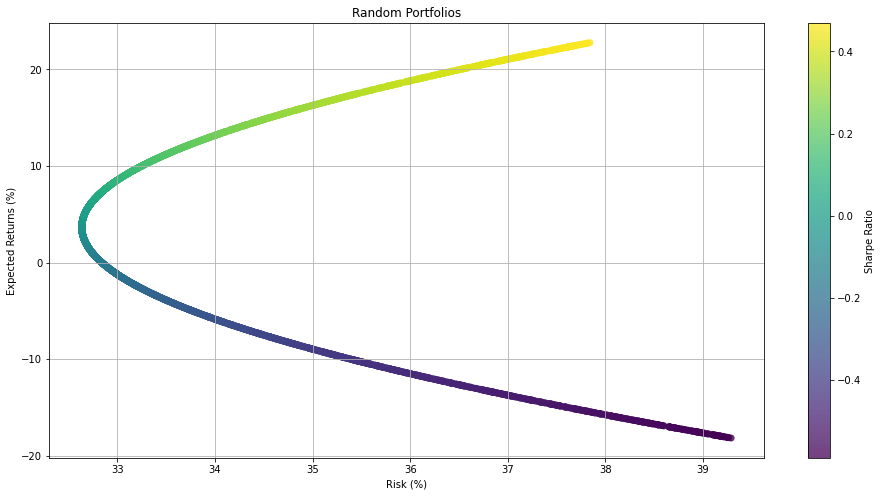

In [39]:
RISK_FREE_RATE = 0.05
MAX_PORTS = 10000
MAX_WEIGHT = 1.05


def port_generator(rets, cov_matrix):
    port_rets = []
    port_risks = []
    port_sharpes = []
    port_weights = []

    for _ in range(MAX_PORTS):
        # weights = np.random.random(len(rets))
        weights = np.random.uniform(-MAX_WEIGHT, MAX_WEIGHT, len(rets))
        weights /= np.sum(weights)  # Normalize weights to 1
        if any(weights > MAX_WEIGHT):
            continue
        port_weights.append(weights)

        port_ret = np.dot(weights, rets)
        port_rets.append(port_ret)

        port_risk = np.sqrt(weights.T @ cov_matrix @ weights)
        port_risks.append(port_risk)

        port_sharpe = (port_ret - RISK_FREE_RATE) / port_risk
        port_sharpes.append(port_sharpe)

    port_rets = np.array(port_rets)
    port_risks = np.array(port_risks)

    plt.scatter(
        port_risks * 100.0,
        port_rets * 100.0,
        c=port_sharpes,
        cmap="viridis",
        alpha=0.75,
    )

    plt.xlabel("Risk (%)")
    plt.ylabel("Expected Returns (%)")
    plt.colorbar(label="Sharpe Ratio")
    plt.grid()

    return port_risks, port_rets, port_sharpes


plt.figure(figsize=(16, 8))
plt.title("Random Portfolios")
port_generator(rets, cov_matrix)
plt.show()

Already we can see a frontier forming. 

Here we add Sharpe Ratios to be able to compare portfolios. The ratio tell us if the portfolio is better than the risk free option, usually if it's 1 or above:

$$ Sharpe = \frac{R_p - R_f}{\sigma_p} $$

where:
- `Rp` is the portfolio returns.
- `Rf` is the risk-free rate. As of 11.2023 this is 5%
- `sigma` is the standard deviation of the portfolio returns.

The ratio was not the best benchmark here, neither the variance calculations, as most stocks in this market regime had extreme positive variance - in this case we would have done better with the Sortino Ratio and half-variance calculations that measures negative risk (less than the risk free rate).

# Finding an Investable Universe

To simplify the process of building portfolios and frontiers, we will ignore riskless lending and borrowing and assume unlimited short selling is possible - this means you'll see negative weights and weights that are more than 100%. All will add up to 100% if you include the negative weights, as we will 'leverage' our long positions with income from the short selling, e.g. -20% DIS and 100 % AAPL:
- We long 100% AAPL, short sell 20% DIS netting us additional funds at the expense of interest and the return of the stock to a counter party (which we are also simplifying out),
- We use the extra 20% gained to buy another 20% of AAPL stock.

The following sections are better described with a larger universe of instruments at a larger timeframe for diversification:

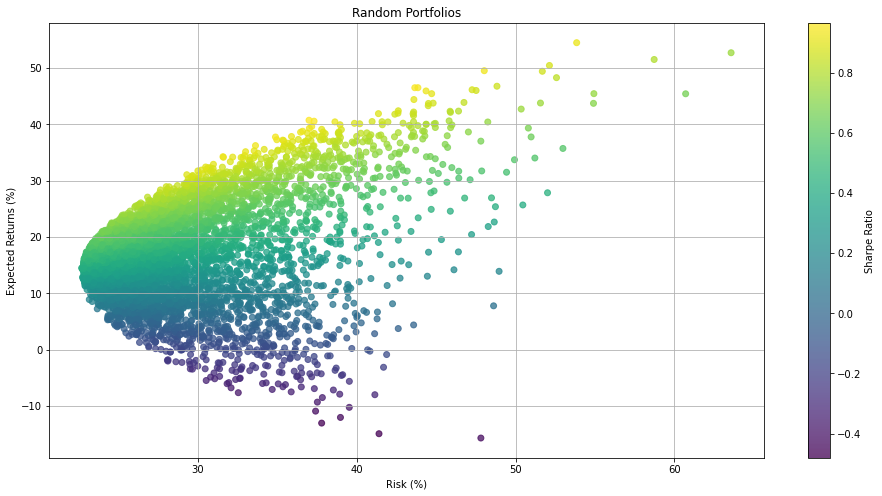

In [40]:
tickers = [
    "AAPL",
    "DIS",
    "MSFT",
    "AMZN",
    "GOOG",
]
START_DATE = "2014-01-01"
END_DATE = "2022-12-31"

tickers_orig_df = load_ticker_prices_ts_df(tickers, START_DATE, END_DATE)
tickers_df = tickers_orig_df.dropna(axis=1).pct_change().dropna()  # first % is NaN

rets = ((1 + tickers_df).prod() ** (TRADING_DAYS_IN_YEAR / len(tickers_df))) - 1
cov_matrix = tickers_df.cov() * TRADING_DAYS_IN_YEAR

plt.figure(figsize=(16, 8))
plt.title("Random Portfolios")
port_risks, port_rets, port_sharpes = port_generator(rets, cov_matrix)
plt.show()

Now lets build 2 portfolios as benchmarks:
1. **Minimum Variance Portfolio (MVP)** - The MVP is the tip of the frontier and the least volatile with adequet returns, any portfolio under it delivers lesser utility to the investor for its risk.
2. **Tangency Portfolio (TAN)** - The Market portfolio on the Capital Market Line (CML), and is the highest point of tageny, maximising the Sharpe Ratio and therefore the risk adjusted returns.

To get to those portfolios, we approximate the inverse of the covariance (called precision matrix) to get the `min_risk_vect` and `expect_ret_vect`  dot products, that will contribute to the risk adjustment.
The MVP solution is straightforwrd, all portfolio attibutes are adjusted by the `min_risk_vect` . The TAN is the same, but adjusted by the `expect_ret_vect` vector.

In [41]:
# Equal-weighted portfolio useful for matrix operations
equal_weights = np.ones(len(rets))

rets = ((1 + tickers_df).prod() ** (TRADING_DAYS_IN_YEAR / len(tickers_df))) - 1
cov_matrix = tickers_df.cov() * TRADING_DAYS_IN_YEAR

# Min variance weights
inv_cov_matrix = np.linalg.pinv(cov_matrix)
min_risk_vect = equal_weights @ inv_cov_matrix
expect_ret_vect = inv_cov_matrix @ rets

# Minimum variance portfolio
# Weights are normalized to sum to 1, and risk to std deviation.
mvp_weights = min_risk_vect / np.sum(min_risk_vect)
mvp_ret = mvp_weights @ rets
mvp_risk = np.sqrt(mvp_weights.T @ cov_matrix @ mvp_weights)

# Tangency portfolio
tan_weights = expect_ret_vect / np.sum(expect_ret_vect)
tan_ret = tan_weights @ rets
tan_risk = np.sqrt(tan_weights.T @ cov_matrix @ tan_weights)

summary_data = {
    "Asset": tickers,
    "MVP Weights": mvp_weights,
    "TAN Weights": tan_weights,
}

print(f"mvp_ret: {mvp_ret*100:0.02f}%, mvp_risk {mvp_risk*100:0.02f}%")
print(f"tan_ret: {tan_ret*100:0.02f}%, tan_risk {tan_risk*100:0.02f}%")

summary_df = pd.DataFrame(summary_data)
summary_df.T

mvp_ret: 13.51%, mvp_risk 22.59%
tan_ret: 47.41%, tan_risk 42.31%


,0,1,2,3,4
Asset,AAPL,DIS,MSFT,AMZN,GOOG
MVP Weights,0.171975,0.395765,0.182245,0.051125,0.19889
TAN Weights,0.806744,-0.684549,1.462342,-0.026828,-0.557708


Let's create a risk curve by solving the portfolio Risk for the MVP and the expected returns:

$$ \sigma_p^2 = w_{\text{mvp}}^2 \cdot \sigma_{\text{mvp}}^2 + w_{\text{E(R)}}^2 \cdot \sigma_{\text{E(R)}}^2 + 2 \cdot w_{\text{mvp}} \cdot w_{\text{E(r)}} \cdot \text{Cov}(R_{\text{mvp}}, E(R)) $$

Where:
- `W mvp` is the weights of all assets in the MVP.
- `E(R)` is the weights associated with the expected returns for all portfolios along the curve.
- `Sigma^2 MVP` is the variance of the returns of the MVP.
- `Sigma^2 E(R)` is the variance of the expected returns of all portfolios.
- `Cov` is the covariance between the returns of the MVP and the expected returns of all portfolios.

The above is normalized by the utility function and square root.

Finally we will add a Market Capital Line (MCL) to represent the market's risk and returns at the time of this analysis, any portfolio under this line might be overpriced and suboptimal, any higher might be underpriced for its risk. 

MCL is calculated on every portofolio as follows:

$$ E(R_p) = R_f + \frac{\sigma_i}{\sigma_M} \cdot (E(R_M) - R_f) $$


Where:
- `E(Rp)`: Expected return on portfolio `i`.
- `Rf`: Risk-free rate, represented by our equal weight portfolio's constant term `c`.
- `Sigma i` and `Sigma m`: Variance of portfolio `i`. In our case its the reciprocal of the risk adjusted market returns, calculated in the quadratic terms `a`.
- `E(RM)-Rf`: Is the product of the returns and MVP, calculated in the linear term `b`.

When plotted against the expected returns, the CML will intercept the efficient frontier at the TAN portfolio, this being the most optimal market portfolio. 

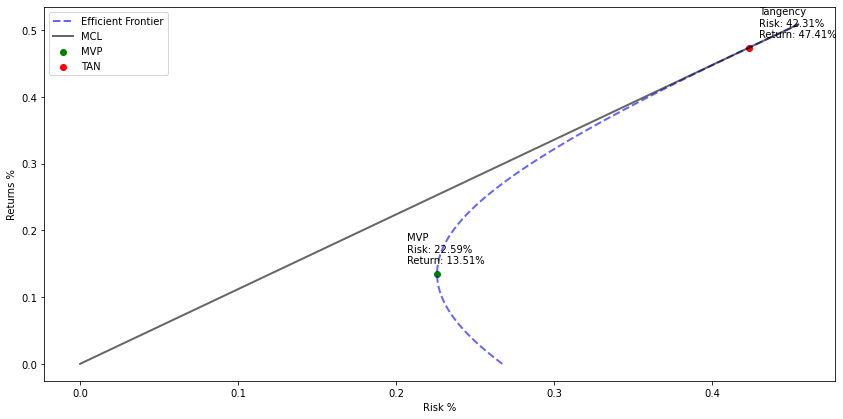

In [42]:
MAX_RETS = 0.51
TEN_BASIS_POINTS = 0.0001 * 10

c = np.sum(equal_weights * min_risk_vect)  # Constant term
b = np.sum(rets * min_risk_vect)  # Linear term
a = np.sum(rets * expect_ret_vect)  # Quadratic term
utility_func = (a * c) + (-(b**2))  # U(X) to penalize risk

# The frontier curve & MCL, scaled by utility function
exp_rets = np.arange(0, MAX_RETS, TEN_BASIS_POINTS)
ports_risk_frontier = np.sqrt(
    ((c * (exp_rets**2)) - (2 * b * exp_rets) + a) / utility_func
)
mcl_vector = exp_rets * (1 / np.sqrt(a))

plt.figure(figsize=(12, 6))
plt.plot(
    ports_risk_frontier,
    exp_rets,
    linestyle="--",
    color="blue",
    label="Efficient Frontier",
    linewidth=2,
    alpha=0.6,
)
plt.plot(
    mcl_vector,
    exp_rets,
    label="MCL",
    linewidth=2,
    alpha=0.6,
    color="black",
)

plt.scatter(mvp_risk, mvp_ret, color="green", label="MVP")
plt.annotate(
    f"MVP\nRisk: {mvp_risk*100:.2f}%\nReturn: {mvp_ret*100:.2f}%",
    (mvp_risk, mvp_ret),
    textcoords="offset points",
    xytext=(-30, 10),
)
plt.scatter(tan_risk, tan_ret, color="red", label="TAN")
plt.annotate(
    f"Tangency\nRisk: {tan_risk*100:.2f}%\nReturn: {tan_ret*100:.2f}%",
    (tan_risk, tan_ret),
    textcoords="offset points",
    xytext=(10, 10),
)

plt.legend(loc="upper left", fontsize=10)
plt.xlabel("Risk %")
plt.ylabel("Returns %")
plt.tight_layout()
plt.show()

With the above formulas, we can solve the optimal portfolio for a target return, by taking the sum of the products of the expected return and the tangent portfolio contributions, and deduct the MVP contributions. We again normalize the weights with the utlity function denominator.

We assume that the target return is never less than the MVP returns:

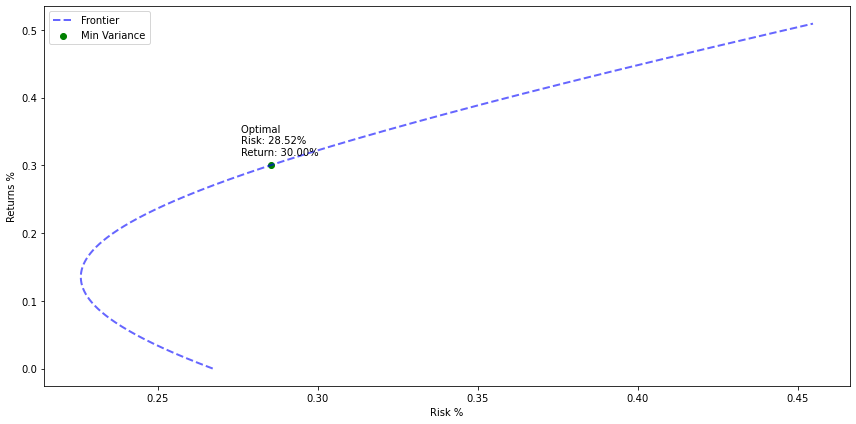

In [43]:
TARGET_RET = 0.3

pt_port = None
opt_risk = None
opt_ret = None

mvp_weights = (a - (b * TARGET_RET)) / utility_func
tan_weights = ((c * TARGET_RET) - b) / utility_func

opt_port_weights = (mvp_weights * min_risk_vect) + (tan_weights * expect_ret_vect)
opt_ret = np.sum(opt_port_weights * rets)
opt_risk = np.sqrt(((c * (opt_ret**2)) - (2 * b * opt_ret) + a) / utility_func)

plt.figure(figsize=(12, 6))
plt.plot(
    ports_risk_frontier,
    exp_rets,
    linestyle="--",
    color="blue",
    label="Frontier",
    linewidth=2,
    alpha=0.6,
)

plt.scatter(opt_risk, opt_ret, color="green", label="Min Variance")
plt.annotate(
    f"Optimal \nRisk: {opt_risk*100:.2f}%\nReturn: {opt_ret*100:.2f}%",
    (opt_risk, opt_ret),
    textcoords="offset points",
    xytext=(-30, 10),
)

plt.legend(loc="upper left", fontsize=10)
plt.xlabel("Risk %")
plt.ylabel("Returns %")
plt.tight_layout()
plt.show()

Let's add everything together in a graph so we can visualize our optimal and frontier portfolios (the lengthy code is available in the notebook):

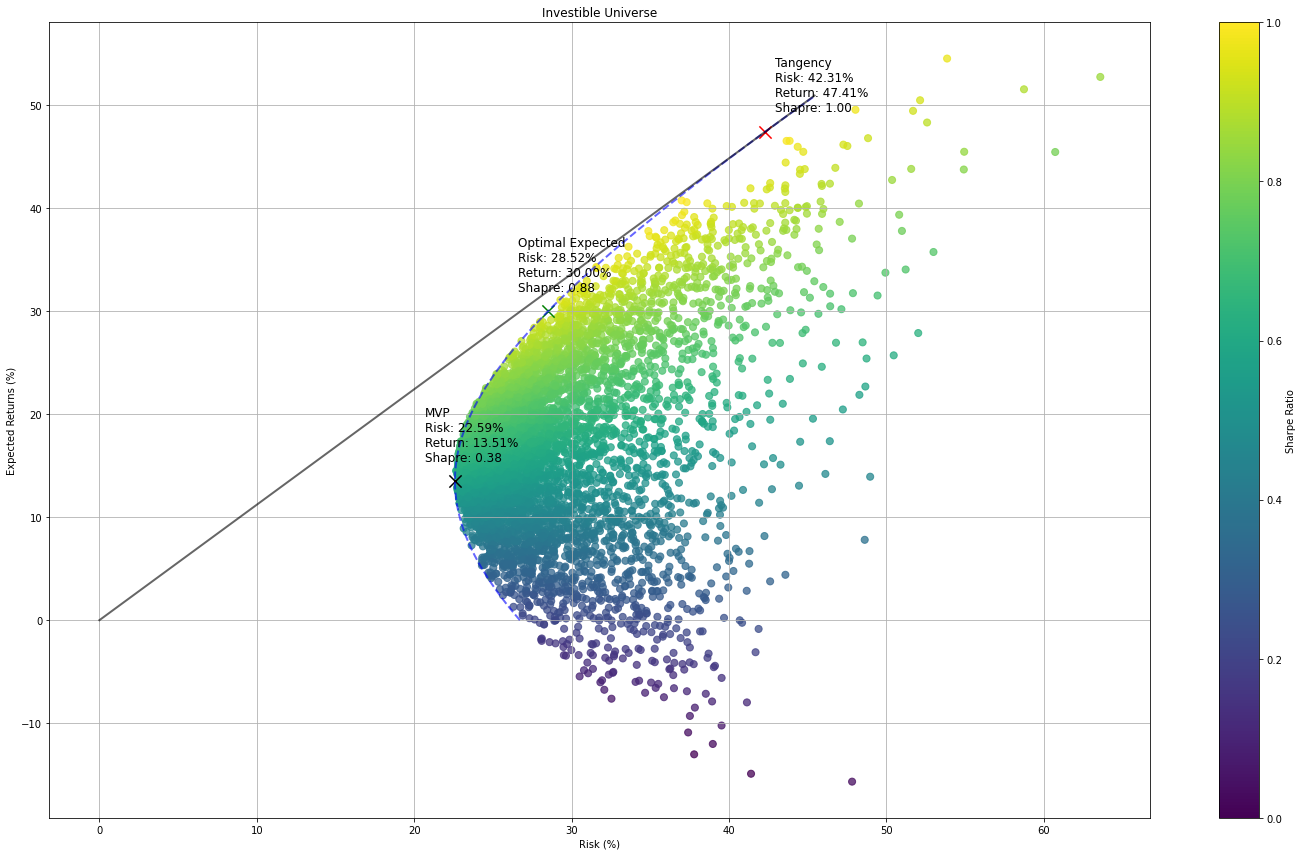

In [44]:
# Add portfolios sharpe
opt_sharpe = (opt_ret - RISK_FREE_RATE) / opt_risk
mvp_sharpe = (mvp_ret - RISK_FREE_RATE) / mvp_risk
tan_sharpe = (tan_ret - RISK_FREE_RATE) / tan_risk

plt.figure(figsize=(20, 12))  # Increase figure size

plt.title("Investible Universe")

plt.scatter(
    port_risks * 100.0,
    port_rets * 100.0,
    c=port_sharpes,
    cmap="viridis",
    alpha=0.75,
    s=50,  # Adjust the size of the scatter points
)

plt.plot(
    ports_risk_frontier * 100,
    exp_rets * 100,
    linestyle="--",
    color="blue",
    label="Frontier",
    linewidth=2,
    alpha=0.6,
)

# Adjust the size of the optimal point
plt.scatter(
    opt_risk * 100,
    opt_ret * 100,
    color="green",
    marker="x",
    s=150,
    label="Optimal Expected Returns",
)
plt.annotate(
    f"Optimal Expected \nRisk: {opt_risk*100:.2f}%\nReturn: {opt_ret*100:.2f}%\nShapre: {opt_sharpe:.2f}",
    (opt_risk * 100, opt_ret * 100),
    textcoords="offset points",
    xytext=(-30, 20),  # Adjust the annotation position
    fontsize=12,  # Adjust the font size
)

plt.plot(
    mcl_vector * 100,
    exp_rets * 100,
    label="MCL",
    linewidth=2,
    alpha=0.6,
    color="black",
)

# Adjust the size and position of the MVP point
plt.scatter(
    mvp_risk * 100,
    mvp_ret * 100,
    color="Black",
    label="MVP",
    marker="x",
    s=150,
)
plt.annotate(
    f"MVP\nRisk: {mvp_risk*100:.2f}%\nReturn: {mvp_ret*100:.2f}%\nShapre: {mvp_sharpe:.2f}",
    (mvp_risk * 100, mvp_ret * 100),
    textcoords="offset points",
    xytext=(-30, 20),
    fontsize=12,
)

# Adjust the size and position of the Tangency point
plt.scatter(
    tan_risk * 100,
    tan_ret * 100,
    color="red",
    label="TAN",
    marker="x",
    s=150,
)
plt.annotate(
    f"Tangency\nRisk: {tan_risk*100:.2f}%\nReturn: {tan_ret*100:.2f}%\nShapre: {tan_sharpe:.2f}",
    (tan_risk * 100, tan_ret * 100),
    textcoords="offset points",
    xytext=(10, 20),
    fontsize=12,
)

plt.xlabel("Risk (%)")
plt.ylabel("Expected Returns (%)")
plt.colorbar(label="Sharpe Ratio")
plt.grid()

plt.tight_layout()
plt.show()

# Conclusion

This was not an easy article to digest, though it described a fundamental topic in quantitative finance. 

We constructed optimal portfolios, showcased the Capital Market Line, and solved portfolios for risk and returns expectations. We understood how the Minimum Variance and Tangency Portfolios are efficient portfolios, and learned to build these from our universe of assets.

Be warned, if you run the above code on the current market regime only (post-covid 2020-2023) you'll see unexpected results or extreme MVP or TAN weights, this is because of the high volatility the market experienced in this period. This is also a spotlight on the weaknesses of the frontier, in that it is dependant on past performance, and is blind to market events and changes in the market regime.


![The MVP built by a quant cowpoke MidJourney 11.2023](https://raw.githubusercontent.com/adamd1985/quant_research/main/images/mvp_ending.png)

## References

- https://www.investopedia.com/terms/i/indifferencecurve.asp
- https://www.investopedia.com/ask/answers/041315/how-covariance-used-portfolio-theory.asp 
- https://www.investopedia.com/ask/answers/what-basis-point-bps/
- https://www.investopedia.com/terms/c/cml.asp


## Github

Article here is also available on [Github](https://github.com/adamd1985/quant_research/blob/main/efficient-frontier-quant.ipynb)

Kaggle notebook available [here](https://www.kaggle.com/code/addarm/solving-the-efficient-frontier-in-stocks)


## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.